## Imports

In [1]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
import numpy as np

## Data Organization

### Pull relevant data

In [2]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [3]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')
df_nutrition.head()

,country_code,country_name,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.361
1,AGO,Angola,57.2,87.1,7.1,92.9,17.0,26.0,27.7,29816.769
2,AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,0.0,13.0,62.2,37.8,0.0,0.4,1.1,2873.457
4,ARE,United Arab Emirates,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9487.206


### Clean it up

In [4]:
# Unwanted columns - Simplify the dataset
unwanted_cols = [
    'support',
    'health',
    'freedom',
    'generosity',
    'corruption',
    'positivity',
    'negativity',
    'calories_pct',
    'nutrients_pct',
    'calories_mills',
    'nutrients_mills',
    'diet_mills'
]

In [5]:
# Function to merge medals with happiness, GDP and nutrition datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    df_merged.drop(unwanted_cols, axis=1, inplace=True, errors='ignore')
    return df_merged

In [6]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

# Summer Data

### Women's Summer

In [9]:
# Women's summer games correlation, collect info nd check dataframe
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   103 non-null    object 
 1   medal_count    103 non-null    int64  
 2   happiness      85 non-null     float64
 3   wealth         84 non-null     float64
 4   gdp_avg        84 non-null     float64
 5   good_diet_pct  69 non-null     float64
 6   bad_diet_pct   72 non-null     float64
 7   population     76 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.6+ KB


In [34]:
# Top and Bottom Womens Summer Games
# Reset index and sort values
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
98,1,5.437579,8.977185,NaN,67.6,32.4,94600.643
99,1,NaN,NaN,1994.08,48.5,51.5,877.460
100,1,7.467971,10.882743,8909.10,NaN,0.0,343.400
101,1,4.315308,7.616090,10820.91,15.2,84.8,41166.588
102,1,5.569637,10.204665,23121.80,96.6,3.4,1942.248


In [10]:
# Set index to country_name and compare correlations
df.set_index('country_name', inplace=True)
correlation_matrix = df.corr()
print(correlation_matrix)

               medal_count  happiness    wealth   gdp_avg  good_diet_pct  \
medal_count       1.000000   0.234169  0.292613  0.831738       0.287825   
happiness         0.234169   1.000000  0.802930  0.208903       0.745038   
wealth            0.292613   0.802930  1.000000  0.228058       0.897316   
gdp_avg           0.831738   0.208903  0.228058  1.000000       0.210865   
good_diet_pct     0.287825   0.745038  0.897316  0.210865       1.000000   
bad_diet_pct     -0.269807  -0.729592 -0.890775 -0.197154      -1.000000   
population        0.313934  -0.178541 -0.159272  0.409605      -0.151061   

               bad_diet_pct  population  
medal_count       -0.269807    0.313934  
happiness         -0.729592   -0.178541  
wealth            -0.890775   -0.159272  
gdp_avg           -0.197154    0.409605  
good_diet_pct     -1.000000   -0.151061  
bad_diet_pct       1.000000    0.159740  
population         0.159740    1.000000  


In [ ]:
#Clean up labels names
df_women_summer.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %',
    'bad_diet_pct': 'Bad Diet %',
    'population': 'Population'
}, inplace=True)

df_women_summer.head(10)

,Medals Won,Happiness,Wealth,GDP per Capita,Good Diet %,Bad Diet %,Population
0,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860
5,203,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
6,154,5.770220,10.115109,126545.07,88.1,11.9,19588.715
7,144,7.440393,10.897109,411682.28,99.6,0.4,17131.296
8,139,6.023527,10.593319,2938993.71,97.5,2.5,126785.797
9,124,7.296854,10.756211,755211.83,99.3,0.7,36545.295


# Correlative Heatmap

In [ ]:
df_medal_details

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1
...,...,...,...,...,...,...,...,...
13125,Winter,UZB,Uzbekistan,Freestyle Skiing,aerials women,Women,GOLD,1
13126,Winter,YUG,Yugoslavia,Alpine Skiing,giant slalom men,Men,SILVER,1
13127,Winter,YUG,Yugoslavia,Alpine Skiing,slalom women,Women,SILVER,1
13128,Winter,YUG,Yugoslavia,Ski Jumping,large hill individual men,Men,BRONZE,1


In [12]:
df_medal_counts = df_medal_details.groupby('country_name')['medal_count'].sum().reset_index()
df_medal_counts


,country_name,medal_count
0,Afghanistan,2
1,Algeria,17
2,Argentina,77
3,Armenia,18
4,Australasia,12
...,...,...
143,"Virgin Islands, US",1
144,West Indies Federation,2
145,Yugoslavia,87
146,Zambia,2


In [13]:
#set csv to variable and audit dataset

df_country_details = pd.read_csv('../data/etl/merged_medal_hap_nut_gdp_by_country.csv')

"""
IMPORTANT NOTES:
In preparation for the correlative analysis, I scoured the dataset and found some things that will impact the overall findings:
• Duplicative Czech Republic with differing medal counts
• Not alphabetically sorted (e.g. Virgin Islands is under "I" and North Korea is under "N" but South Korea is under "K")
• Korea North and South are separated (does not account for pre-separatist movement, no Republic of Korea to be found)
• "MIX" has 23 medals but unknown what it actually is (mixed team designation) — this is not a country, and therefore we do not include it in the dataset based on our existing parameters
• "Unified team" has 135 medals, also not a country and does not fit into our filtering / models
• West Indies Federation and Yugoslavia do not exist anymore and therefore cannot be reconciled with the comparative data which accounts for more recent years
"""

'\nIMPORTANT NOTES:\nIn preparation for the correlative analysis, I scoured the dataset and found some things that will impact the overall findings:\n• Duplicative Czech Republic with differing medal counts\n• Not alphabetically sorted (e.g. Virgin Islands is under "I" and North Korea is under "N" but South Korea is under "K")\n• Korea North and South are separated (does not account for pre-separatist movement, no Republic of Korea to be found)\n• "MIX" has 23 medals but unknown what it actually is (mixed team designation) — this is not a country, and therefore we do not include it in the dataset based on our existing parameters\n• "Unified team" has 135 medals, also not a country and does not fit into our filtering / models\n• West Indies Federation and Yugoslavia do not exist anymore and therefore cannot be reconciled with the comparative data which accounts for more recent years\n'

In [14]:
# Viewing the dataframe
df_country_details.head()

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
0,Afghanistan,2,3.219917,7.585624,0.476654,52.711667,0.480475,0.056325,0.835824,0.421804,0.370840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13093.44
1,Netherlands Antilles,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,17,5.391880,9.338236,0.811683,66.136363,0.520711,-0.132543,0.688052,0.540448,0.266245,0.2,7.2,64.8,35.2,0.1,3.0,14.6,41389.174,79710.57
3,Australasia,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,77,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,0.3,7.1,89.0,11.0,0.1,3.1,4.8,44044.811,317986.22


In [18]:
df_variables = df_country_details.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'support': 'Support',
    'health': 'Health',
    'freedom': 'Freedom',
    'generosity': 'Generosity',
    'corruption': 'Corruption',
    'positivity': 'Positivity',
    'negativity': 'Negativity',
    'calories_avg': 'Daily Calories',
    'nutrients_avg': 'Daily Nutrients',
    'calories_pct': 'Daily Calories by %',
    'nutrients_pct': 'Daily Nutrients by %',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %',
    'bad_diet_pct': 'Bad Diet %',
    'calories_mills' : "Daily Calories by Millions",
    'nutrients_mills' : "Daily Nutrients by Millions",
    'diet_mills' : "Diet by Millions",
    'population': 'Population'
}, inplace=True)

,Medals Won,Happiness,Wealth,Support,Health,Freedom,Generosity,Corruption,Positivity,Negativity,Daily Calories by %,Daily Nutrients by %,Good Diet %,Bad Diet %,Daily Calories by Millions,Daily Nutrients by Millions,Diet by Millions,Population,GDP per Capita
Medals Won,1.000000,0.355586,0.357803,0.291602,0.284972,0.175840,0.144428,-0.198347,0.164676,-0.204697,-0.160419,-0.301940,0.356910,-0.343019,-0.052136,-0.052336,-0.047440,0.229562,0.858683
Happiness,0.355586,1.000000,0.816091,0.762118,0.763315,0.652632,0.325894,-0.562221,0.601594,-0.372836,-0.445801,-0.701876,0.761900,-0.754073,-0.192630,-0.208925,-0.212301,-0.116704,0.237327
Wealth,0.357803,0.816091,1.000000,0.730850,0.816775,0.497857,0.092069,-0.458153,0.298551,-0.279036,-0.552569,-0.872884,0.895549,-0.892065,-0.246917,-0.218126,-0.219779,-0.103476,0.248334
Support,0.291602,0.762118,0.730850,1.000000,0.646804,0.499487,0.134438,-0.292140,0.488799,-0.486312,-0.501859,-0.691144,0.730155,-0.720806,-0.217100,-0.328746,-0.341011,-0.185146,0.182812
Health,0.284972,0.763315,0.816775,0.646804,1.000000,0.430558,0.050002,-0.350378,0.280501,-0.190660,-0.607838,-0.853124,0.851832,-0.846876,-0.293222,-0.177807,-0.173161,-0.043193,0.195896


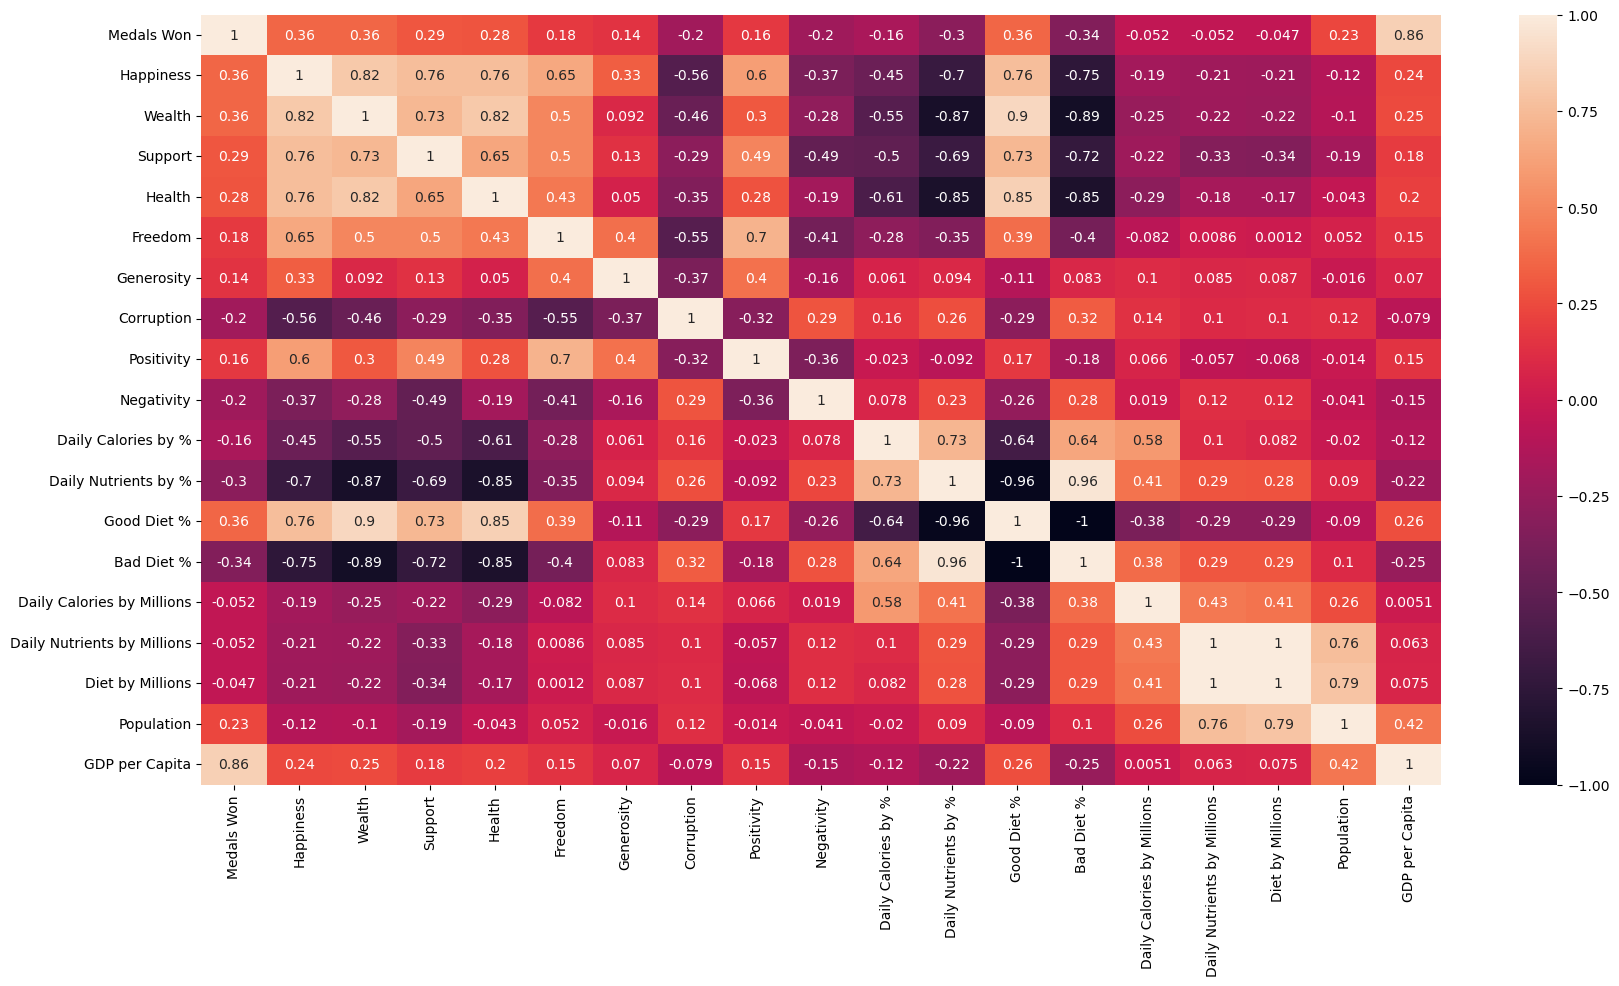

In [22]:
# Correlation heatmap initial

plt.figure(figsize=(20, 10))
df_corr = df_country_details.drop('country_name', axis=1).corr()
sns.heatmap(df_corr, annot=True)

df_corr.head()

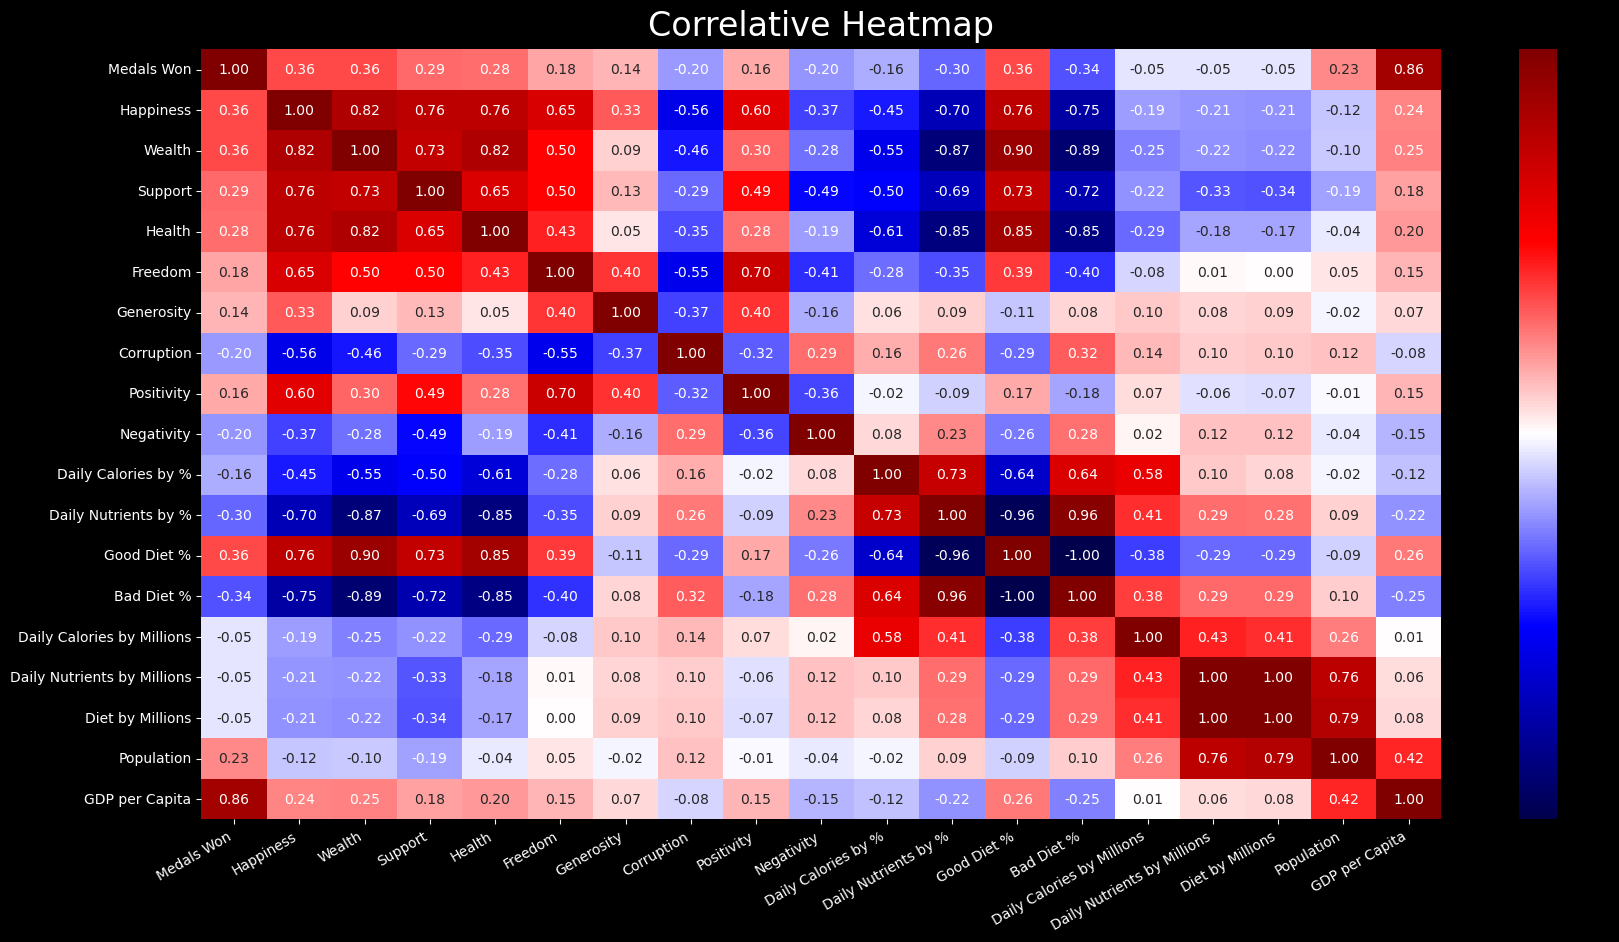

In [ ]:
# General heatmap correlation of all variables, adjusted tones

# Create a heatmap
img, ax = plt.subplots(figsize=(20, 10))
df_corr = df_country_details.drop('country_name', axis=1).corr()
ax = sns.heatmap(df_corr, annot=True, cmap= 'seismic', annot_kws={"size": 10}, fmt=".2f")

# Update axes to cleaner labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

#Adjust style values to match dark theme
img.patch.set_facecolor('black')
ax.set_facecolor('black')

#Adjust style values to match dark theme
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Create output
plt.title('Correlative Heatmap', fontsize=24, pad=10)
plt.show()


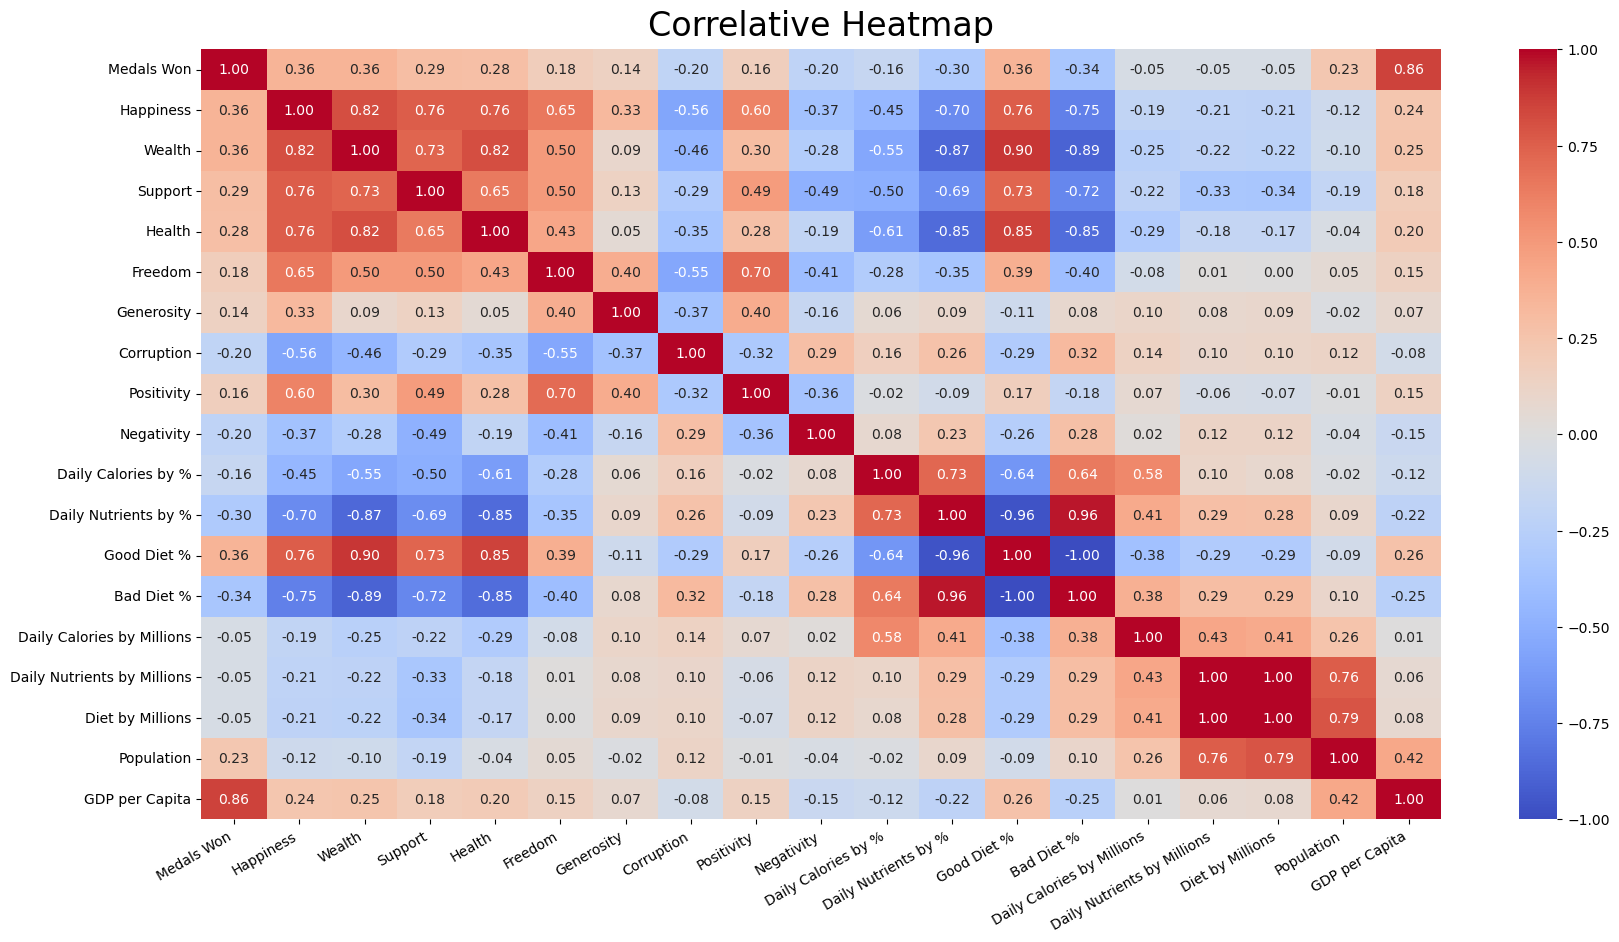

In [24]:
# General heatmap correlation of all variables, adjusted tones

# Create a heatmap
ax = plt.subplots(figsize=(20, 10))
df_corr = df_country_details.drop('country_name', axis=1).corr()
ax = sns.heatmap(df_corr, annot=True, cmap= 'coolwarm', annot_kws={"size": 10}, fmt=".2f")

# Update axes to cleaner labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Create output
plt.title('Correlative Heatmap', fontsize=24, pad=10)
plt.show()